###**Preparing the dataset**

Prepare the dataset using Labelme annotation tool (for Instance segmentation) and LabelImg for object detection.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###**Installing Detectron2 on Colab**

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

###**Register the data to Detectron2 config**

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 512
        record["width"] = 640
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                #"segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
classes = ['bottle']

data_path = '/content/drive/MyDrive/Resoluteai/detectron2/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category1" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category1" + d).set(thing_dataset_id_to_contiguous_id=classes)

microcontroller_metadata = MetadataCatalog.get("category1train")

###**Training the Detectron2 Instance Segmentation Model**

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category1train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[04/15 07:25:46 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  pixel_mean
  pixel_std


In [ ]:
trainer.train()

[04/15 07:25:49 d2.engine.train_loop]: Starting training from iteration 0
[04/15 07:25:59 d2.utils.events]:  eta: 0:00:41  iter: 19  total_loss: 1.601  loss_cls: 1.011  loss_box_reg: 0.6558  time: 0.5206  data_time: 0.0209  lr: 4.7703e-05  max_mem: 5715M
[04/15 07:26:10 d2.utils.events]:  eta: 0:00:31  iter: 39  total_loss: 0.6337  loss_cls: 0.2669  loss_box_reg: 0.4104  time: 0.5220  data_time: 0.0092  lr: 9.7653e-05  max_mem: 5715M
[04/15 07:26:20 d2.utils.events]:  eta: 0:00:20  iter: 59  total_loss: 0.3333  loss_cls: 0.1225  loss_box_reg: 0.2183  time: 0.5097  data_time: 0.0093  lr: 0.0001476  max_mem: 5715M
[04/15 07:26:29 d2.utils.events]:  eta: 0:00:10  iter: 79  total_loss: 0.211  loss_cls: 0.05833  loss_box_reg: 0.1571  time: 0.5023  data_time: 0.0099  lr: 0.00019755  max_mem: 5715M
[04/15 07:26:41 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 0.1732  loss_cls: 0.03503  loss_box_reg: 0.1405  time: 0.5034  data_time: 0.0131  lr: 0.0002475  max_mem: 5715M
[04/15 07:26:4

###**Inference using the Trained Model**

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [ ]:
# len(test_dataset_dicts) = 7, 7 dictionaries in a list (7 images for test)
# test_dataset_dicts[0] = each dict containing 4 keys: 'file_name', 'height', 'width', 'annotations'

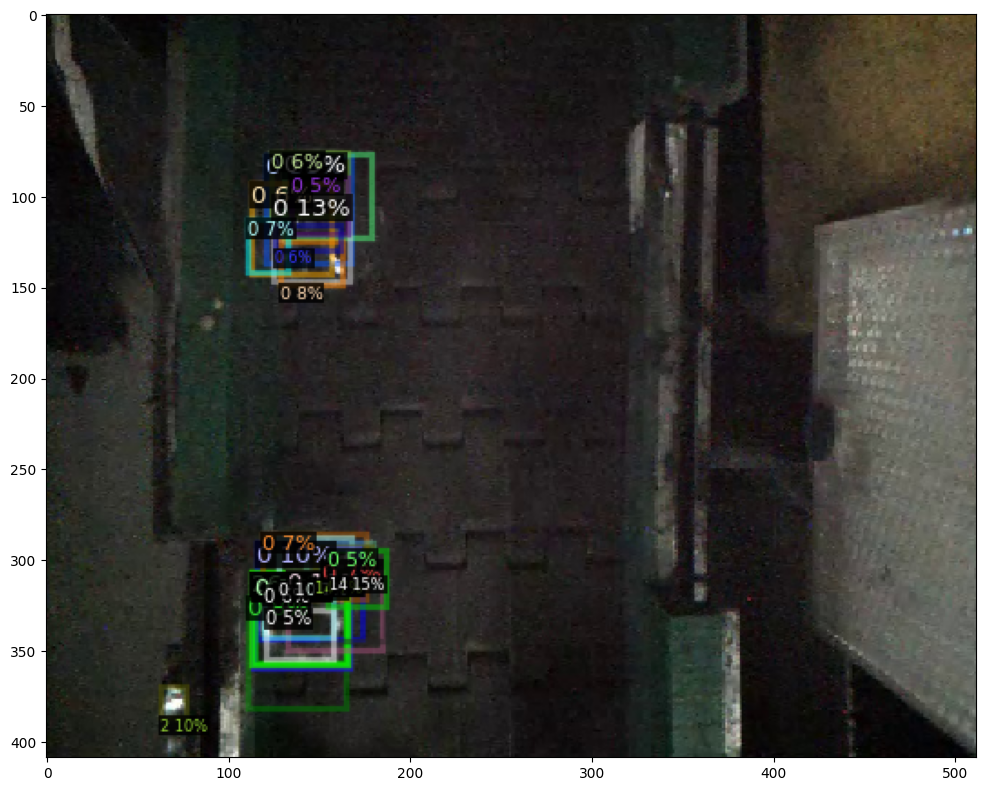

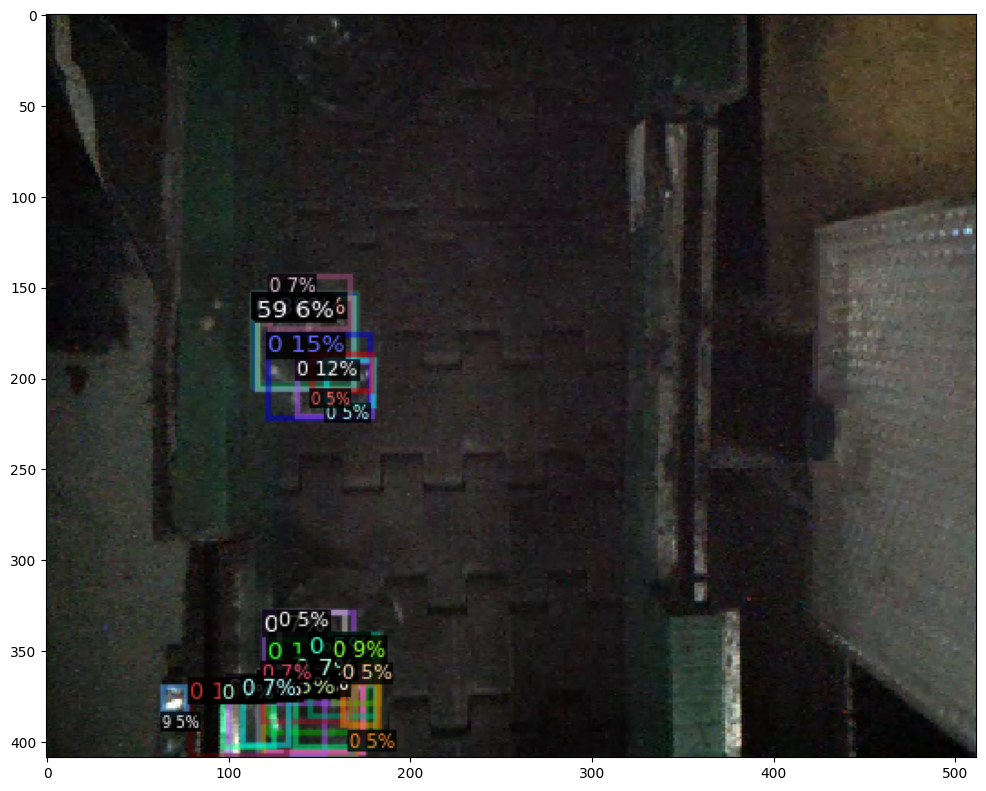

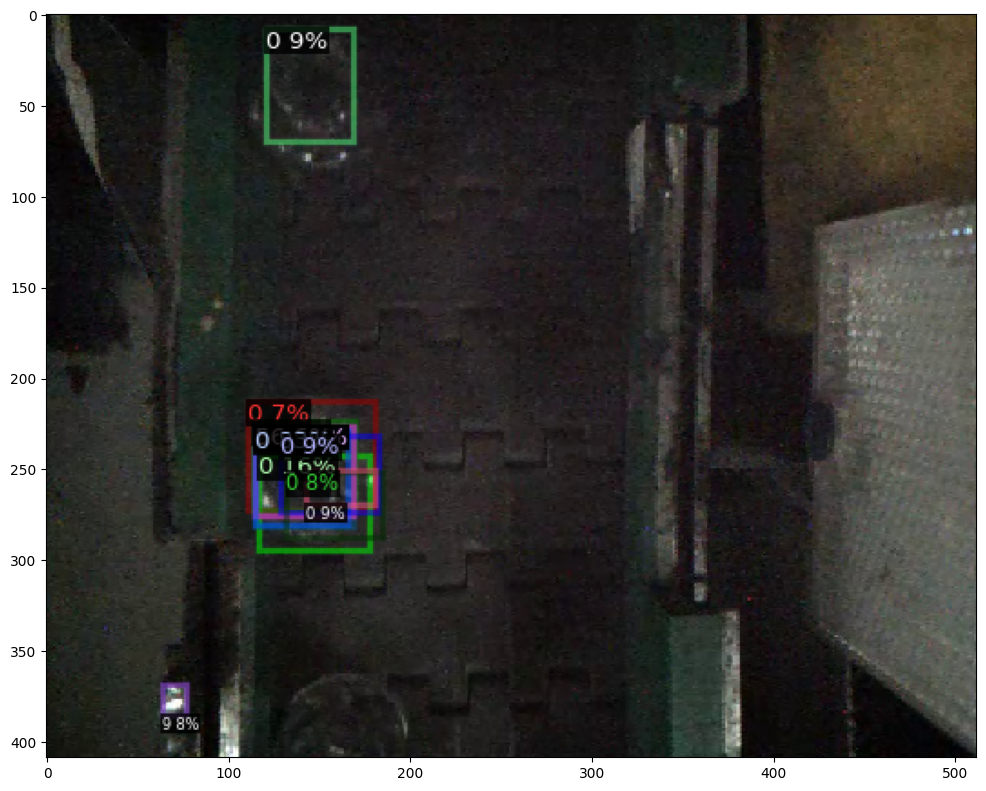

In [ ]:
for d in random.sample(test_dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    #v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (12, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()